In [21]:
import numpy as np
import matplotlib.pyplot as plt

from monte_carlo import ExactMCAgent, MCAgent
from envs.gridworld import GridworldEnv
from utils.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

In [2]:
nx, ny = 4, 4
env = GridworldEnv([ny, nx])

In [3]:
mc_agent = ExactMCAgent(gamma=1.0,
                        num_states=nx * ny,
                        num_actions=4,
                        epsilon=1.0)

In [4]:
action_mapper = {
    0: 'UP',
    1: 'RIGHT',
    2: 'DOWN',
    3: 'LEFT'
}

In [5]:
step_counter = 0
while True:
    print("At t = {}".format(step_counter))
    #env._render()
    
    cur_state = env.observe()
    action = mc_agent.get_action(cur_state)
    next_state, reward, done, info = env.step(action)
    
    print("state : {}".format(cur_state))
    print("aciton : {}".format(action_mapper[action]))
    print("reward : {}".format(reward))
    print("next state : {} \n".format(next_state))
    step_counter += 1
    if done:
        break

At t = 0
state : 1
aciton : RIGHT
reward : -1.0
next state : 2 

At t = 1
state : 2
aciton : LEFT
reward : -1.0
next state : 1 

At t = 2
state : 1
aciton : RIGHT
reward : -1.0
next state : 2 

At t = 3
state : 2
aciton : DOWN
reward : -1.0
next state : 6 

At t = 4
state : 6
aciton : DOWN
reward : -1.0
next state : 10 

At t = 5
state : 10
aciton : UP
reward : -1.0
next state : 6 

At t = 6
state : 6
aciton : DOWN
reward : -1.0
next state : 10 

At t = 7
state : 10
aciton : DOWN
reward : -1.0
next state : 14 

At t = 8
state : 14
aciton : RIGHT
reward : -1.0
next state : 15 



In [6]:
def run_episode(env, agent):
    env.reset()
    states = []
    actions = []
    rewards = []
    
    while True:
        state = env.observe()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    episode = (states, actions, rewards)
    agent.update(episode)

In [7]:
%%time
mc_agent.reset_statistics()
for _ in range(10):  
    run_episode(env, mc_agent)

Wall time: 6.18 ms


In [8]:
mc_agent.compute_values()

In [9]:
mc_agent.v

array([  0.        , -21.75      , -15.33333333, -16.27777778,
       -13.45454545, -23.        , -18.14285714, -12.33333333,
       -24.75      , -29.875     , -15.5       , -12.2       ,
       -40.52631579, -34.25      , -18.66666667,   0.        ])

## Monte-carlo 방식으로 추산한 $V(s)$ 이 정말 맞을까요?

우리는 이 `GridworldEnv` 에 대해서 정답을 알고 있죠? 바로 `동적 계획법`을 통해서 계산한 $V(s)$ 입니다. 여기서는 `Monte-carlo` 로 추산한 가치함수와 동적 계획법으로 계산한 가치함수의 값을 비교해볼까요?

In [10]:
from tensorized_dp import TensorDP

dp_agent = TensorDP()
dp_agent.set_env(env)

Tensor DP agent initialized
Environment spec:  Num. state = 16 | Num. actions = 4 


In [11]:
%%time
v_pi = dp_agent.policy_evaluation()

Wall time: 2.99 ms


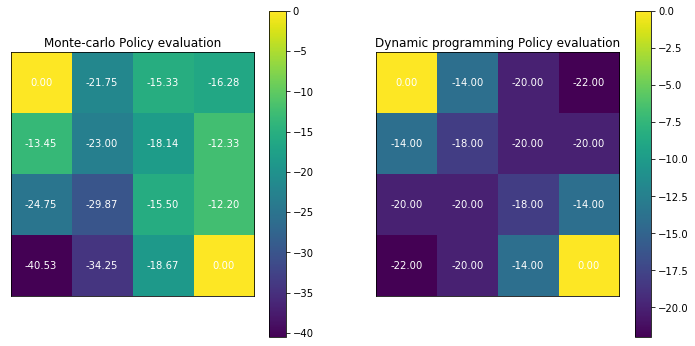

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Monte-carlo Policy evaluation")

visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("Dynamic programming Policy evaluation")

## Monte-carlo 기법에 실망하셨나요? 

`dp_agent` 와 `mc_agent`에게 비슷한 시간을 주고 가치 함수를 평가해봤었는데
`mc_agent` 의 결과가 영 시원치 않죠? 바로 `MDP` 환경모델을 활용 여부에 따른 차이입니다.

`dp_agent`는 환경에 대해 훤히 알고 있으니, 짧은 시간 (혹은 계산) 만에 원하는 답을 알아내는 것은
어쩌면 당연하겠죠. `mc_agent`에게 조금 더 시간을 줘 보는게 어떨까요?

In [13]:
total_eps = 2000
log_every = 500

def run_episodes(env, agent, total_eps, log_every):
    mc_values = []
    log_iters = []

    agent.reset_statistics()
    for i in range(total_eps+1):  
        run_episode(env, agent)

        if i % log_every == 0:
            agent.compute_values()
            mc_values.append(agent.v.copy())
            log_iters.append(i)
    
    info = dict()
    info['values'] = mc_values
    info['iters'] = log_iters
    return info

In [14]:
info = run_episodes(env, mc_agent, total_eps, log_every)

In [15]:
log_iters = info['iters']
mc_values = info['values']

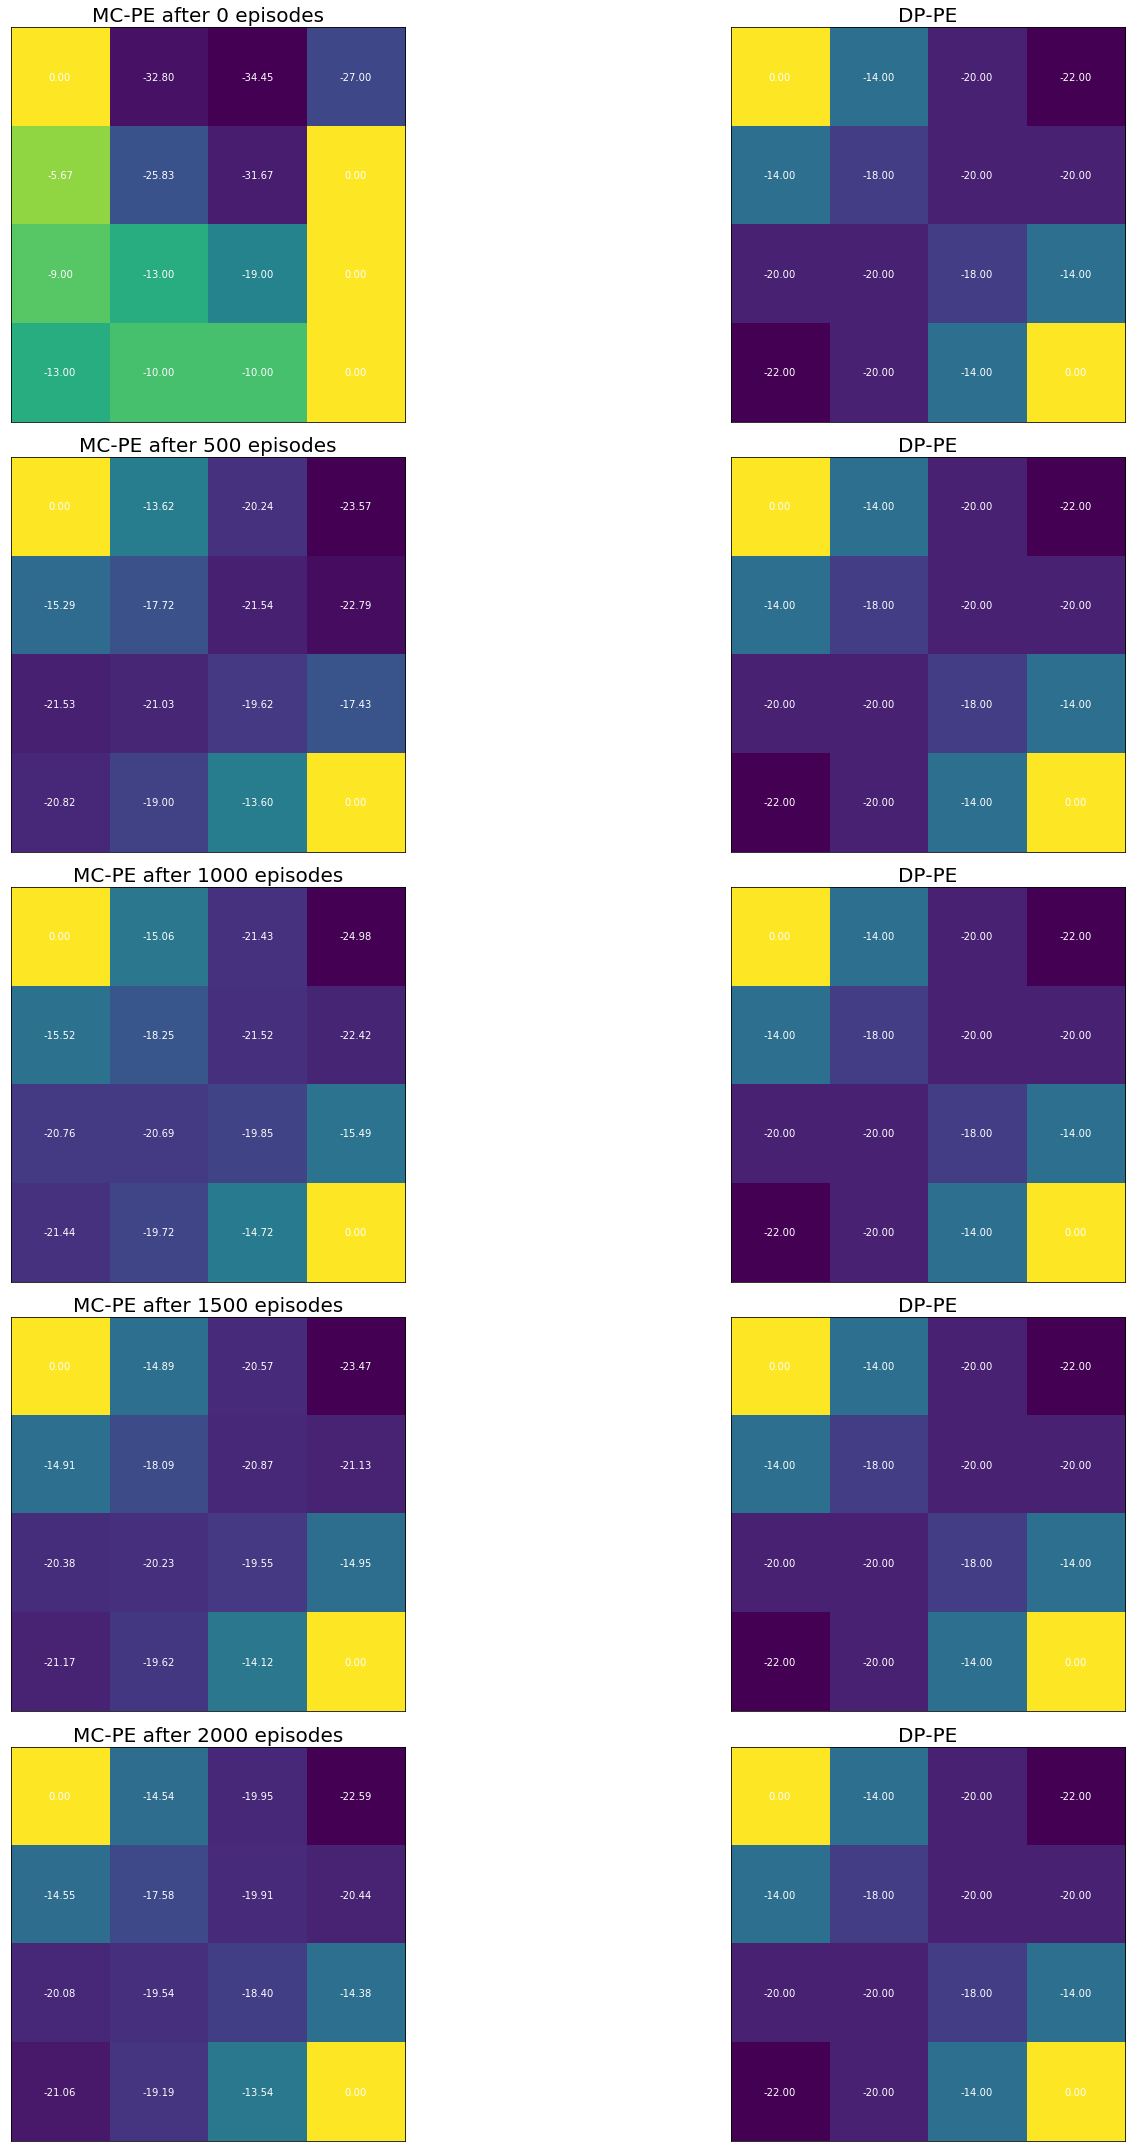

In [16]:
n_rows = len(log_iters)
figsize_multiplier = 10


fig, ax = plt.subplots(n_rows, 2, figsize=(n_rows*figsize_multiplier*0.5, 
                                           3*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], mc_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("MC-PE after {} episodes".format(i), size=20)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=20)

fig.tight_layout()

## 혹시 눈치 채셨나요? 매 실행마다 결과값이 달라진다는 것을?

Monte-carlo Policy evaluation 에서는 매 실행마다, 가치함수 추산값이 달라지는것을 확인하셨나요?
그러면 한번 매 실행마다 얼마나 결과값이 다른지, 즉, 가치함수 `추산치의 분산`이 얼마나 되는지 확인해볼까요?

In [17]:
reps = 10
values_over_runs = []
total_eps = 3000
log_every = 30

for i in range(reps):
    print("start to run {} th experiment ... ".format(i))
    info = run_episodes(env, mc_agent, total_eps, log_every)
    values_over_runs.append(info['values'])
    
values_over_runs = np.stack(values_over_runs)

start to run 0 th experiment ... 
start to run 1 th experiment ... 
start to run 2 th experiment ... 
start to run 3 th experiment ... 
start to run 4 th experiment ... 
start to run 5 th experiment ... 
start to run 6 th experiment ... 
start to run 7 th experiment ... 
start to run 8 th experiment ... 
start to run 9 th experiment ... 


In [18]:
v_pi_expanded = np.expand_dims(v_pi, axis=(0,1))

In [19]:
errors = np.linalg.norm(values_over_runs - v_pi_expanded, axis=-1)
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis=0)

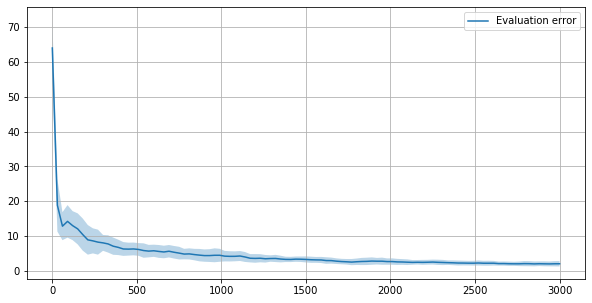

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.fill_between(x=info['iters'],
                y1=error_mean + error_std,
                y2=error_mean - error_std,
                alpha=0.3)
ax.plot(info['iters'], error_mean, label='Evaluation error')
ax.legend()

In [75]:
mc_agent = MCAgent(gamma=1.0,
                   lr=1e-3,
                   num_states=nx * ny,
                   num_actions=4,
                   epsilon=1.0)

In [76]:
mc_agent.reset_values()

In [80]:
for _ in range(5000):
    run_episode(env, mc_agent)

In [81]:
mc_agent.v

array([  0.        , -14.60999441, -21.53882097, -22.47683279,
       -14.61310735, -18.85215823, -21.25796729, -20.10179957,
       -20.31602721, -20.5156456 , -18.61537147, -14.66874774,
       -21.92067238, -20.1867743 , -13.43103759,   0.        ])

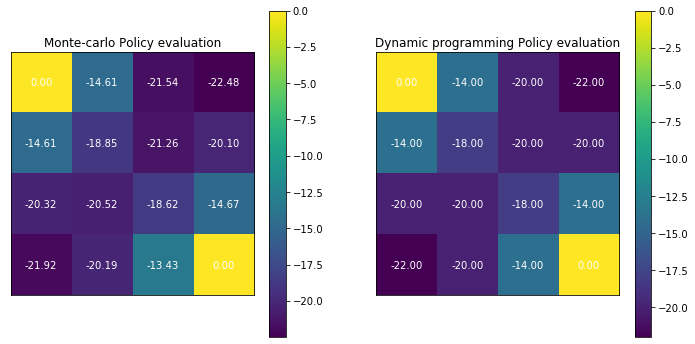

In [82]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Monte-carlo Policy evaluation")

visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("Dynamic programming Policy evaluation")